In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from highlight_text import fig_text, ax_text
from pyfonts import load_font, set_default_font

In [2]:
shows = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-07-29/shows.csv')

In [3]:
shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27803 entries, 0 to 27802
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   source              27803 non-null  object 
 1   report              27803 non-null  object 
 2   title               27797 non-null  object 
 3   available_globally  27794 non-null  object 
 4   release_date        13770 non-null  object 
 5   hours_viewed        27791 non-null  float64
 6   runtime             27089 non-null  object 
 7   views               27791 non-null  float64
dtypes: float64(2), object(6)
memory usage: 1.7+ MB


In [4]:
shows.head(2)

,source,report,title,available_globally,release_date,hours_viewed,runtime,views
0,1_What_We_Watched_A_Netflix_Engagement_Report_...,2025Jan-Jun,Adolescence: Limited Series,Yes,2025-03-13,555100000.0,3H 50M 0S,144800000.0
1,1_What_We_Watched_A_Netflix_Engagement_Report_...,2025Jan-Jun,Squid Game: Season 2 // 오징어 게임: 시즌 2,Yes,2024-12-26,840300000.0,7H 10M 0S,117300000.0


In [5]:
def extract_season(title):
    if not isinstance(title, str):
        return None
    match = re.search(r'[Ss]eason\s*(\d+)', title)
    return int(match.group(1)) if match else None

shows['season'] = shows['title'].apply(extract_season)

In [6]:
shows_with_season = shows.dropna(subset=['season'])

In [7]:
shows_with_season.head(2)

,source,report,title,available_globally,release_date,hours_viewed,runtime,views,season
1,1_What_We_Watched_A_Netflix_Engagement_Report_...,2025Jan-Jun,Squid Game: Season 2 // 오징어 게임: 시즌 2,Yes,2024-12-26,840300000.0,7H 10M 0S,117300000.0,2.0
2,1_What_We_Watched_A_Netflix_Engagement_Report_...,2025Jan-Jun,Squid Game: Season 3 // 오징어 게임: 시즌 3,Yes,2025-06-27,438600000.0,6H 8M 0S,71500000.0,3.0


In [8]:
shows_with_season = shows_with_season.copy()
shows_with_season["main_title"] = shows_with_season["title"].str.split(":").str[0]

In [9]:
multi_season = shows_with_season.groupby('main_title').filter(lambda x: x['season'].nunique() > 1)

In [10]:
selected_list = ["Peaky Blinders", "Lost (2004)", "Vikings (2013)", "Animal Kingdom", "The Crown", "BoJack Horseman", "House of Cards",
                 "This Is Us", "Star Trek", "Sex and the City", "I AM A KILLER", "Orange Is the New Black"]

In [11]:
df_selected = multi_season[multi_season["main_title"].isin(selected_list)]

In [12]:
df_selected = df_selected[df_selected["season"]!=7]

In [13]:
agg_selected = df_selected.groupby("main_title")[["views"]].sum().sort_values(by="views", ascending=False)

In [14]:
selected_titles = agg_selected.index.to_list()

In [15]:
by_season = df_selected.groupby(["main_title", "season"])[["views"]].sum()

In [16]:
by_season  = by_season .reset_index()

In [17]:
# Custom order
by_season ['main_title'] = pd.Categorical(by_season ['main_title'], categories=selected_titles, ordered=True)

# Sort by custom order
df = by_season .sort_values(by=['main_title', 'season'])

In [18]:
df = df.reset_index()

In [19]:
agg_selected = agg_selected.reset_index()

In [20]:
df = pd.merge(df, agg_selected, on="main_title", how="left", suffixes=('_season', '_total'))

In [21]:
df1 = df.groupby("main_title")["views_season"].mean().round(3).reset_index() 

In [22]:
df = pd.merge(df, df1, on="main_title", how="left", suffixes=('', '_mean'))

In [23]:
df["views_pos"] = (df["views_season"] - df["views_season_mean"]).round(1)

In [24]:
# Modify views_season based on views_pos's values
def adjust_pos(row):
    if row['views_pos'] < 0:
        return row['views_season'] * -1
    return row['views_season']

df['views_season'] = df.apply(adjust_pos, axis=1)

In [25]:
bebas_neue = load_font(
  font_url="https://github.com/google/fonts/blob/main/ofl/bebasneue/BebasNeue-Regular.ttf?raw=true"
)
set_default_font(bebas_neue)

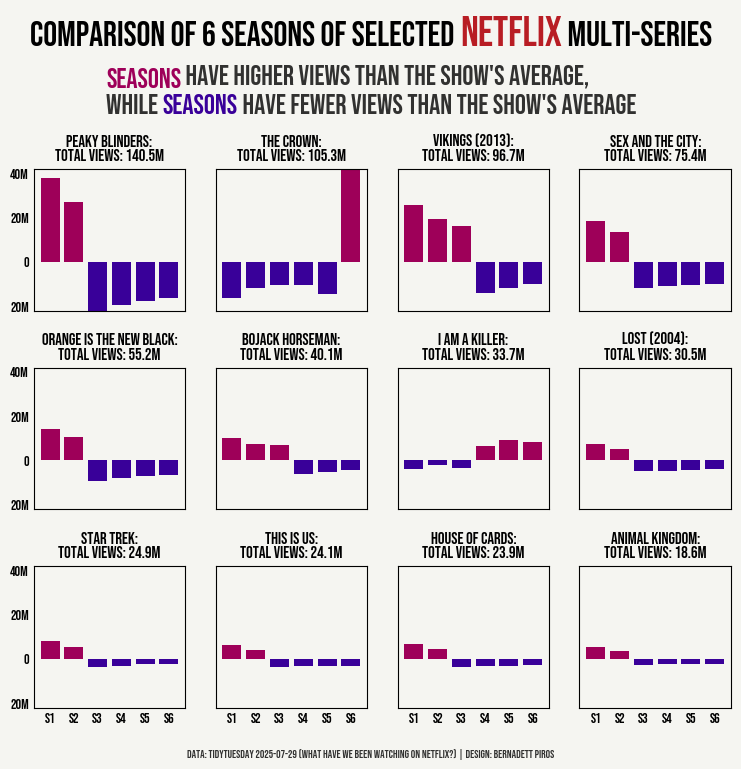

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(9, 7), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.4)
axes = axes.flatten()

titles = df['main_title'].unique()

for i, title in enumerate(titles):    
    title_data = df[df['main_title'] == title]       

     # Calculate the total value
    total = title_data['views_total'].mean()
    # Format the total value to 2 decimals
    total_formatted = f"Total views: {total/1e6:.1f}M"
    
    ax = axes[i]        
    
    colors = ['#9e0059' if value > 0 else '#390099' for value in title_data['views_season']]    
    ax.bar(title_data['season'], title_data['views_season'], color=colors)    
    
    ax.set_title(f"{title}:\n{total_formatted}")       
    ax.set_ylim(df['views_season'].min(), df['views_season'].max())    
    ax.set_facecolor("#F5F5F1")
    
    locationx = [1, 2, 3, 4, 5, 6]    
    labelsx = ["S1", "S2", "S3", "S4", "S5", "S6"]    
    ax.set_xticks(locationx, labels=labelsx)

    locationy = [-2e7, 0, 2e7, 4e7]    
    labelsy = ["20M", "0", "20M", "40M"]    
    ax.set_yticks(locationy, labels=labelsy)    

    ax.tick_params(length=0)    

fig.set_facecolor("#F5F5F1")

fig_text(0.5, 1.1, s="Comparison of 6 seasons of selected <Netflix> multi-series",
        fontsize=25, ha="center", highlight_textprops=[
            {"color": '#b81d24', "fontsize":30},
                    ]      
        )

fig_text(0.5, 1.03, s="<Seasons> have higher views than the show's average,\nwhile <seasons> have fewer views than the show's average",
        fontsize=20, ha="center", alpha=0.8, highlight_textprops=[
            {"color": '#9e0059', "alpha":1},
            {"color": '#390099', "alpha":1}
        ]      
        )

fig.text(0.5, 0.04, "Data: TidyTuesday 2025-07-29 (What have we been watching on Netflix?) | Design: Bernadett Piros", alpha=0.8, fontsize=8, ha="center")

plt.show()

#fig.savefig("2025-07-29.png", bbox_inches='tight', pad_inches=0.2)